# Problem Description

The Titanic was the name of the ship that set sail many years ago that attempted to cross the Atlantic from East to West.  However, it struck an iceberg and as a result many people died.  The problem being solved here is to figure out what attributes for a passenger contribute to their likelihood of survival and then build a model to predict who would have survived and not survived.

# Exploratory Data Analysis

First, we will set up our libraries and take a brief look at the data set to understand the different columns.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('titanic.csv')
df.head()
# 'SibSp' is the total count of spouse and siblings
# 'Parch' is the total count of parents and children
# 'Survived' shows 0 for 'no', he/she did not survive and 1 for 'yes', he/she did survive

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing Data

We will use a seaborn heatmap to identify where we are missing data.

In [3]:
df.isnull() # This is the first look for missing data.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


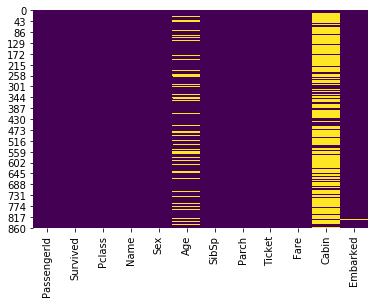

In [4]:
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

As shown in the chart above, a substantial amount of 'Age' information is missing.  I will use average 'Age' to fill in the missing values.

Almost all values in the 'Cabin' column are missing.  I will drop this column later

          Ticket
Survived        
0            549
1            342


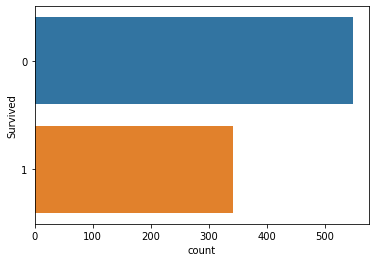

In [5]:
sns.countplot(y='Survived', data = df)
print(pd.pivot_table(df, index = 'Survived', values = 'Ticket', aggfunc = 'count'))

In the chart above, 549 people did not survive compared to 342 people who did survive.

Sex       female  male
Survived              
0             81   468
1            233   109


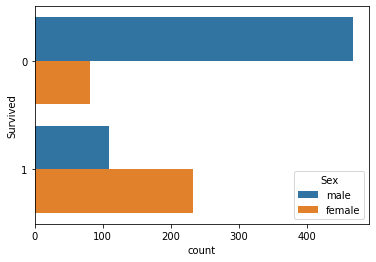

In [6]:
sns.countplot(y='Survived',hue='Sex', data = df)
print(pd.pivot_table(df, index = 'Survived', columns = 'Sex', values = 'Ticket', aggfunc = 'count'))

In the charts above, 468 men did not survive compared to 81 women.  Of the survivors, 233 were women compared to 109 men.

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


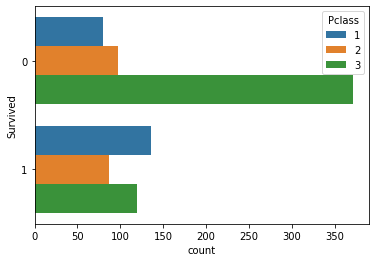

In [7]:
sns.countplot(y='Survived', hue = 'Pclass', data = df)
print(pd.pivot_table(df, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc = 'count'))

In the chart above, over 372 3rd class passengers did not survive compared to 80 and 97 1st and 2nd class passengers respectively.

Of the survivors, the splits were close to even amount 1st, 2nd and 3rd class passengers.

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


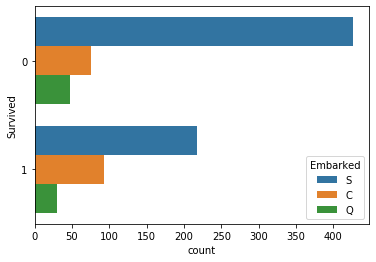

In [8]:
sns.countplot(y='Survived', hue = 'Embarked', data = df)
print(pd.pivot_table(df, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc = 'count'))

In the chart above, most passengers embarked from the location 'S'.  I did not see a correlation between embarcation location and survival.

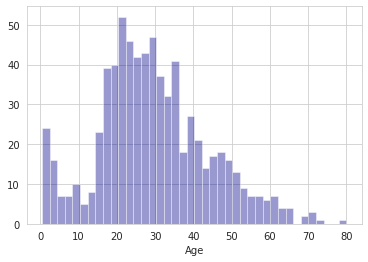

In [9]:
sns.set_style('whitegrid')
sns.distplot(df['Age'].dropna(),kde=False, color = 'darkblue', bins=40)

In the chart above, most people were between the ages of 16 to 32.

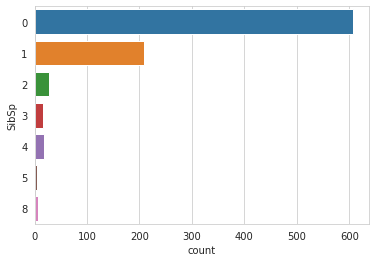

In [10]:
sns.countplot(y='SibSp', data = df)

In the chart above, most people did not have sibling or spouse.  A substantial number travelled with 1 sibling or spouse.

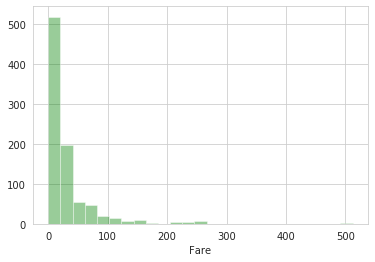

In [11]:
sns.distplot(df['Fare'],kde=False, color = 'green', bins=25)

In the chart above, most people paid under 20 dollars for their fare.  A substantial number paid 20 to 40 dollars for their fare.

## Data Cleaning

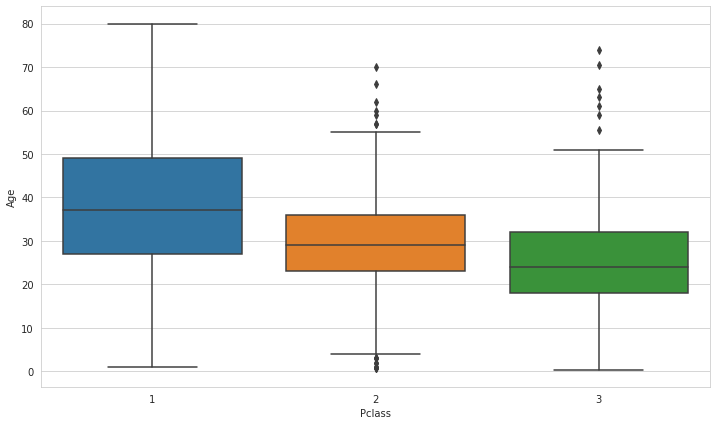

In [12]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass',y='Age', data = df)

The chart above shows a relationship between passenger class and age.  The average age for 1st class passenger is 37.  The average age for 2nd class passenger is 29.  The average age for the 3rd class passenger is 24.

In [13]:
def fix_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now we will use this function to fill in the blank values for Age

In [14]:
df['Age'] = df[['Age','Pclass']].apply(fix_age,axis=1)

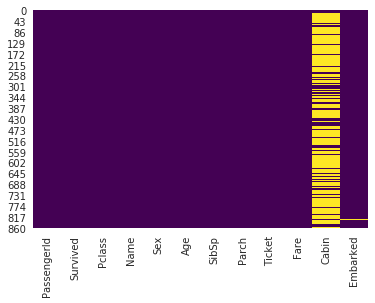

In [15]:
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

The heatmap above now shows no null values for 'Age'

I will now drop the Cabin column and the row where 'Embarked' has a null value

In [16]:
df.drop('Cabin',axis=1,inplace=True)

In [17]:
df.dropna(inplace=True) # Code to drop the row where 'Embarked' has a null value

## Convert Category columns

In [18]:
df.info()# I want to see which columns need to be converted to show 0s and 1s instead.
#The 2 that will be changed are 'Sex' and 'Embarked'.  Others will be deleted.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [19]:
pd.get_dummies(df['Embarked'],drop_first=True).head() 
#the 2nd record under 'Q' and 'S' shows 0 and 0.  This is for the embarkation code, 'C'.

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [20]:
## Getting dummy variables for 'Sex' and 'Embarked'
sex = pd.get_dummies(df['Sex'],drop_first=True)
embark = pd.get_dummies(df['Embarked'],drop_first=True)

In the code below, I will drop the 'Sex' and 'Embarked' columns because I am creating dummy variables.  I am also dropping 'Name' and 'Ticket' columns because I don't need them.

In [21]:
df.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
# I am throwing out 'Fare' as well because it is correlated with 'Pclass'

In [22]:
df = pd.concat([df,sex,embark],axis=1)# Concatenating my data frame with the newly created columns.

In [23]:
df.head()## Preview of my new dataframe.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


# Analysis (model building and training)

## Let's split the data between training and testing

In [24]:
X = df.drop('Survived',axis=1) # We are dropping this column because this is what we are trying to predict
X.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


In [25]:
Y = df['Survived']# This is the column that we will use for our prediction comparison.
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state=100)
# random_state variable is a pseudo-random number generator state used for random sampling.

## Logistic Model Train, Predict and Results

Accuracy and metrics are highly biased upon how the split was performed.  It depends upon whether the data set was shuffled, which part was taken for training and testing.  That is why I am doing a cross validation below.

In [35]:
logisticmodel = LogisticRegression(max_iter=1000)
logisticmodel.fit(X_train, y_train)
scores = cross_val_score(logisticmodel,X_train, y_train)
print("Logistic Model cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
pred = logisticmodel.predict(X_test)
print('Logistic Model confusion matrix:')
print(confusion_matrix(y_test, pred))
print('Logistic Model accuracy score:', accuracy_score(y_test,pred))
print('Logistic Model F1 score:', f1_score(y_test,pred))

Logistic Model cross-val mean-accuracy: 0.813
Logistic Model confusion matrix:
[[137  23]
 [ 34  73]]
Logistic Model accuracy score: 0.7865168539325843
Logistic Model F1 score: 0.7192118226600985


## Support Vector Classification Train, Predict and Results

In [36]:
nlvsm = SVC()
nlvsm.fit(X_train, y_train)
scores = cross_val_score(nlvsm,X_train, y_train)
print("Support Vector Classification cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
pred = nlvsm.predict(X_test)
print('Support Vector Classification confusion matrix:')
print(confusion_matrix(y_test, pred))
print('Support Vector Classification accuracy score:',accuracy_score(y_test,pred))
print('Support Vector Classification F1 score:',f1_score(y_test,pred))

Support Vector Classification cross-val mean-accuracy: 0.646
Support Vector Classification confusion matrix:
[[156   4]
 [ 94  13]]
Support Vector Classification accuracy score: 0.6329588014981273
Support Vector Classification F1 score: 0.2096774193548387


## Decision Tree Classifier Train, Predict and Results

In [37]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
scores = cross_val_score(clf,X_train, y_train)
print("Decision Tree Classifier cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
pred = clf.predict(X_test)
print('Decision Tree Classifier confusion matrix:')
print(confusion_matrix(y_test, pred))
print('Decision Tree Classifier accuracy score:',accuracy_score(y_test,pred))
print('Decision Tree Classifier F1 score:',f1_score(y_test,pred))

Decision Tree Classifier cross-val mean-accuracy: 0.751
Decision Tree Classifier confusion matrix:
[[127  33]
 [ 40  67]]
Decision Tree Classifier accuracy score: 0.7265917602996255
Decision Tree Classifier F1 score: 0.6473429951690821


## KNN Train, Predict and Results

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
scores = cross_val_score(knn,X_train, y_train)
print("KNN Classifier cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
pred = knn.predict(X_test)
print('KNN Classifier confusion matrix:')
print(confusion_matrix(y_test, pred))
print('KNN Classifier accuracy score:',accuracy_score(y_test,pred))
print('KNN Classifier F1 score:',f1_score(y_test,pred))

KNN Classifier cross-val mean-accuracy: 0.650
KNN Classifier confusion matrix:
[[131  29]
 [ 78  29]]
KNN Classifier accuracy score: 0.599250936329588
KNN Classifier F1 score: 0.3515151515151515


## Random Forest Train, Predict and Results

In [39]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
scores = cross_val_score(rfc,X_train, y_train)
print("Random Forest Classifier cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
pred = rfc.predict(X_test)
print('Random Forest Classifier confusion matrix:')
print(confusion_matrix(y_test, pred))
print('Random Forest Classifier accuracy score:',accuracy_score(y_test,pred))
print('Random Forest Classifier F1 score:',f1_score(y_test,pred))

Random Forest Classifier cross-val mean-accuracy: 0.814
Random Forest Classifier confusion matrix:
[[145  15]
 [ 38  69]]
Random Forest Classifier accuracy score: 0.8014981273408239
Random Forest Classifier F1 score: 0.7225130890052355


# Discusssion / Conclusion

From this data set, if we predicted all did not survive then our baseline accuracy is:
61.6%, which is 549 non-survivors/(342 survivors + 549 non-survivors).

So with our best model, we should see accuracy significantly higher than 61.6%.

Out of the 5 models used, the Random Forest Model had the best accuracy of 80.1%
In order these were the accuracy results:
- Random Forest (80.1%)
- Logistic Model (78.7%)
- Decision Tree (72.7%)
- Support Vector (63.3%)
- K Nearest Neighbor (59.9%)

In [40]:
print(confusion_matrix(y_test, pred))

[[145  15]
 [ 38  69]]


Looking at the confustion matrix results above, my model accurately predicted:
- 145 passengers did NOT survive
- 69 passengers DID survive

And the model incorrectly predicted:
- 15 passengers survive when they DID NOT
- 38 passengers DID NOT survive when they actually did

However, as mentioned this data set is unbalanced.  If we predicted all would not survive, we would be 61.6% accurate.  
So that's why F1 score should be the performance metric that decides which model is better.  F1 score is a blend of the precision and recall metrics.
Out of the 5 models used, once again the Random Forest Model had the best F1 score:
- Random Forest (72.3%)
- Logistic Model (71.9%)
- Decision Tree (64.7%)
- K Nearest Neighbor (35.2%)
- Support Vector (20.9%)

So why was Random Forest so much better than Support Vector?

Random Forest is an ensemble model which is an aggregated model of Decision Trees.  Instead of relying on 1 tree, the Random Forest takes the prediction from each tree and based on the majority votes of predictions, it make a final prediction.

Random Forests are better suited for problems that have a mixture of numerical and categorical features.  

On the other hand, support vector machines are better suited for problems where we are looking for distances between 2 points.